___
## ABC Classification

The dataset is a dummy dataset which was scaled for analysis.


The steps that we will be doing here are :
- **Generate the ABC classifcation by Channel, LOB and Category for the products**
- **Create coefficient of variation for the products**
- **Perform an EDA on the ABC classification**
- **Litrature on the application of ABC / coefficient of variation in Supply chain**


In [91]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from datetime import datetime, timedelta
%matplotlib inline

___
### Read in data

In [92]:
df = pd.read_csv('Superstore\salesdata.csv', encoding='latin')

___
## Exploratory data analysis

### The below look into the data show us that this is a sales dataset at - [Channel, Line of business, Category, Product] level

In [93]:
df.head()

,Channel,LOB,Product,Category,Total Volume Eaches
0,Channel 1,LOB 1,Product 1,Category 1,5921
1,Channel 1,LOB 2,Product 2,Category 2,2
2,Channel 1,LOB 2,Product 3,Category 2,3
3,Channel 1,LOB 2,Product 4,Category 2,1
4,Channel 1,LOB 2,Product 5,Category 2,1


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12699 entries, 0 to 12698
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Channel              12699 non-null  object
 1   LOB                  12699 non-null  object
 2   Product              12699 non-null  object
 3   Category             12699 non-null  object
 4   Total Volume Eaches  12699 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 496.2+ KB


In [95]:
df['Total Volume Eaches'] = df['Total Volume Eaches'].astype('float')

### The summary statistics of the measure variables (volumes)

In [96]:
df.describe()

,Total Volume Eaches
count,1.269900e+04
mean,2.529220e+03
std,3.458955e+04
min,-4.000000e+01
25%,1.200000e+01
50%,6.000000e+01
75%,3.420000e+02
max,2.564830e+06


### Literature : ABC Classification

The ABC classification follows the power law y=ax^k which says Distribution of many phenomena across a population follow a Power Law relationship.

These can be seen in from various examples in our daily life
Severity of hurricanes and earthquakes
* Income within a population (Pareto’s Law)
* Visits to websites (Nielsen’s Law) & blogs
* Frequency of words in any language (Zipf’s Law)
* Frequency of digits within tables (Benford’s Law)
* Frequency of authors citations in literature (Lotka’s Law)
* Profitability of customers & products
* Questions from students in a class

> ***The important few versus the trivial many***

#### We assume that Company has operations (Supply Network) is divided into channels and each has dedicated infrastructure to manage the demand from the its corresponding area.
#### Then with the above information we look at how can we calculate ABC classification of the products of company in each of the Channel, LOB and Category 

In [97]:
df.columns

Index(['Channel', 'LOB', 'Product', 'Category', 'Total Volume Eaches'], dtype='object')

In [98]:
### For ABC Calculations we only need last 6 months of data

### Here we aggregate the data at a ['Region','Category', 'Product ID'] since we have customer order level information.

In [99]:
abcvol = df.pivot_table(values=['Total Volume Eaches'], index=['Channel', 'LOB', 'Product', 'Category'], aggfunc='sum')
abcvol.reset_index(inplace=True)

#### The below is a recursive function used to calculate the ABC Class

In [100]:
def abcchannel(abcvol, x=0.8, y=0.15, z=.05):
    sc=abcvol['Channel'].unique()
    for i,j in enumerate(sc):
        tempsc = abcvol.loc[abcvol['Channel']==j,]
        if (i == 0):
            abc1 = abclob(tempsc,x,y,z)
        else:
            abc1 = pd.concat([abc1, abclob(tempsc,x,y,z)])
    return abc1

def abclob(abcvol, x=0.8, y=0.15, z=.05):
    sc=abcvol['LOB'].unique()
    for i,j in enumerate(sc):
        tempsc = abcvol.loc[abcvol['LOB']==j,]
        if (i == 0):
            abc2 = abccategory(tempsc,x,y,z)
        else:
            abc2 = pd.concat([abc2, abccategory(tempsc,x,y,z)])
    return abc2

def abccategory(abcvol, x=0.8, y=0.15, z=.05):
    sc=abcvol['Category'].unique()
    for i,j in enumerate(sc):
        tempsc = abcvol.loc[abcvol['Category']==j,]
        if (i == 0):
            abc3 = abcproduct(tempsc,x,y,z)
        else:
            abc3 = pd.concat([abc3, abcproduct(tempsc,x,y,z)])
    return abc3

def abcproduct(abcvol, x=0.8, y=0.15, z=.05):
    data = abcvol
    data = data.sort_values(by='Total Volume Eaches',ascending=False)
    data['CumSum'] = np.cumsum(data['Total Volume Eaches'].sort_values(ascending=False).values)
    total = data['Total Volume Eaches'].sum()
    count = data.shape[0]
    acutoff = x * total
    bcutoff = acutoff + (y * total)
    ccutoff = bcutoff + (z * total)
    data['ABC'] = 'D'
    data.loc[(data['CumSum'] <= acutoff) & (data['ABC'] == "D"),'ABC'] = "A"
    data.loc[(data['CumSum'] <= bcutoff) & (data['ABC'] == "D"),'ABC'] = "B"
    data.loc[data['ABC'] == "D",'ABC'] = "C"
    
    return data


In [101]:
abc = abcchannel(abcvol).rename({'CumSum':'Sales Cumulative'}, axis=1).reset_index(drop=True)

### View into the generated dataset with the ABC Classification

In [102]:
abc.head()

,Channel,LOB,Product,Category,Total Volume Eaches,Sales Cumulative,ABC
0,Channel 1,LOB 1,Product 1621,Category 1,503197.0,503197.0,A
1,Channel 1,LOB 1,Product 1433,Category 1,151222.0,654419.0,A
2,Channel 1,LOB 1,Product 1440,Category 1,108458.0,762877.0,A
3,Channel 1,LOB 1,Product 143,Category 1,91889.0,854766.0,A
4,Channel 1,LOB 1,Product 170,Category 1,91702.0,946468.0,A


In [103]:
abc.to_csv('abc.csv', index=False)

### Aggregation of the Sales Generated for different Region/Categories for each ABC. Note the high values in the A Class and the low values in the C class

In [104]:
summaryvolume = abc.pivot_table(values='Total Volume Eaches', index=['Channel','LOB','Category'], columns='ABC', aggfunc='sum', margins='all').iloc[:-1]
summaryvolume.reset_index(inplace = True)
summaryvolume[summaryvolume['Channel']=='Channel 1']

ABC,Channel,LOB,Category,A,B,C,All
0,Channel 1,LOB 1,Category 1,1516770.0,284879.0,96443.0,1898092.0
1,Channel 1,LOB 1,Category 2,113978.0,21410.0,7161.0,142549.0
2,Channel 1,LOB 1,Category 3,2296381.0,516960.0,149653.0,2962994.0
3,Channel 1,LOB 1,Category 4,1028.0,211.0,66.0,1305.0
4,Channel 1,LOB 2,Category 1,101975.0,19432.0,6490.0,127897.0
5,Channel 1,LOB 2,Category 2,202592.0,38173.0,12734.0,253499.0
6,Channel 1,LOB 2,Category 3,719074.0,148103.0,46682.0,913859.0
7,Channel 1,LOB 2,Category 4,12802.0,2622.0,833.0,16257.0


### The percenage of sales for the different class in each region and Category
### e.g. Channel 1 / Category A=79.91% B=15.01% C=5.09% ~ 100% (Due to rounding off)

In [105]:
summarypercet = pd.crosstab(values=abc['Total Volume Eaches'], index=[abc.Channel,abc.LOB,abc.Category], columns=abc.ABC, aggfunc='sum',normalize='index').round(4)*100
summarypercet.reset_index(inplace = True)
summarypercet[summarypercet['Channel']=='Channel 1']

ABC,Channel,LOB,Category,A,B,C
0,Channel 1,LOB 1,Category 1,79.91,15.01,5.08
1,Channel 1,LOB 1,Category 2,79.96,15.02,5.02
2,Channel 1,LOB 1,Category 3,77.50,17.45,5.05
3,Channel 1,LOB 1,Category 4,78.77,16.17,5.06
4,Channel 1,LOB 2,Category 1,79.73,15.19,5.07
5,Channel 1,LOB 2,Category 2,79.92,15.06,5.02
6,Channel 1,LOB 2,Category 3,78.69,16.21,5.11
7,Channel 1,LOB 2,Category 4,78.75,16.13,5.12


### Now lets look at the distribution of the SKU's in each of the classifications
Most of the time you can see that the numbers in B and C class are higher than A class

In [106]:
summerycount = abc.pivot_table(values='Total Volume Eaches', index=['Channel','LOB','Category'], columns='ABC', aggfunc='count', margins='all').iloc[:-1]
summerycount.reset_index(inplace = True)
summerycount[summerycount['Channel']=='Channel 1']

ABC,Channel,LOB,Category,A,B,C,All
0,Channel 1,LOB 1,Category 1,26,53,416,495
1,Channel 1,LOB 1,Category 2,141,176,448,765
2,Channel 1,LOB 1,Category 3,8,17,77,102
3,Channel 1,LOB 1,Category 4,9,12,20,41
4,Channel 1,LOB 2,Category 1,32,47,269,348
5,Channel 1,LOB 2,Category 2,120,186,703,1009
6,Channel 1,LOB 2,Category 3,7,30,72,109
7,Channel 1,LOB 2,Category 4,4,9,46,59


### Looking at the % spread of the SKU's 

In [107]:
summerycountpercent = pd.crosstab(values=abc['Total Volume Eaches'], index=[abc.Channel,abc.LOB,abc.Category], columns=abc.ABC, aggfunc='count',normalize='index')
summerycountpercent.reset_index(inplace = True)
summerycountpercent[summerycountpercent['Channel']=='Channel 1']

ABC,Channel,LOB,Category,A,B,C
0,Channel 1,LOB 1,Category 1,0.052525,0.107071,0.840404
1,Channel 1,LOB 1,Category 2,0.184314,0.230065,0.585621
2,Channel 1,LOB 1,Category 3,0.078431,0.166667,0.754902
3,Channel 1,LOB 1,Category 4,0.219512,0.292683,0.487805
4,Channel 1,LOB 2,Category 1,0.091954,0.135057,0.772989
5,Channel 1,LOB 2,Category 2,0.118930,0.184341,0.696729
6,Channel 1,LOB 2,Category 3,0.064220,0.275229,0.660550
7,Channel 1,LOB 2,Category 4,0.067797,0.152542,0.779661


In [108]:
### Plotting the ABC classification
plt.rcParams['figure.figsize']=16,6

> From the below plots we can see that the A class items drives the majority of the sales for the company and it has comparitatively lower number of SKU's associated with it. Hence manging them better is of utmost importance.

Text(0.5, 1.0, 'Category 4')

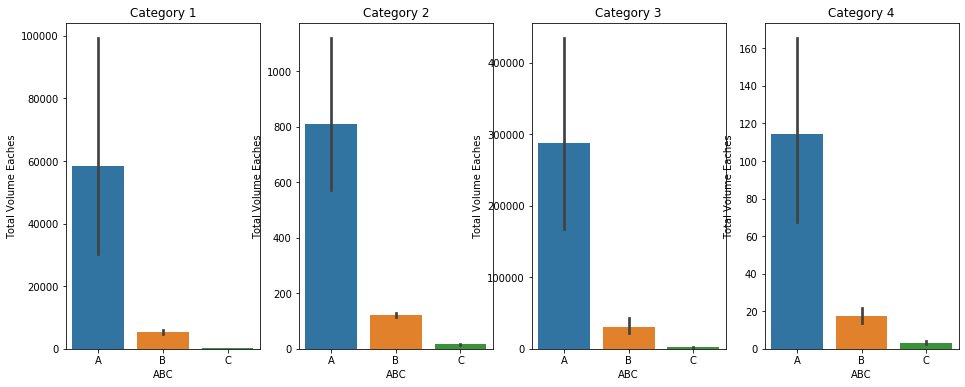

In [109]:
#abc
fig, axs = plt.subplots(ncols=4)
subset = (abc['Channel'] == 'Channel 1') & (abc['LOB'] == 'LOB 1') & (abc['Category']=='Category 1')
sns.barplot(data = abc[subset],x = 'ABC',y = 'Total Volume Eaches',ax=axs[0])
axs[0].set_title('Category 1')
subset = (abc['Channel'] == 'Channel 1') & (abc['LOB'] == 'LOB 1') & (abc['Category']=='Category 2')
sns.barplot(data = abc[subset],x = 'ABC',y = 'Total Volume Eaches',ax=axs[1])
axs[1].set_title('Category 2')
subset = (abc['Channel'] == 'Channel 1') & (abc['LOB'] == 'LOB 1') & (abc['Category']=='Category 3')
sns.barplot(data = abc[subset],x = 'ABC',y = 'Total Volume Eaches',ax=axs[2])
axs[2].set_title('Category 3')
subset = (abc['Channel'] == 'Channel 1') & (abc['LOB'] == 'LOB 1') & (abc['Category']=='Category 4')
sns.barplot(data = abc[subset],x = 'ABC',y = 'Total Volume Eaches',ax=axs[3])
axs[3].set_title('Category 4')

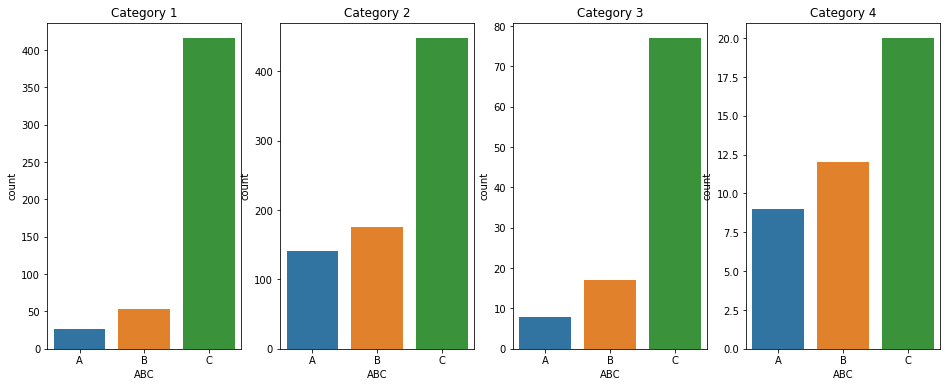

In [110]:
#abc
fig, axs = plt.subplots(ncols=4)
subset = (abc['Channel'] == 'Channel 1') & (abc['LOB'] == 'LOB 1') & (abc['Category']=='Category 1')
sns.countplot(data = abc[subset],x = 'ABC',ax=axs[0])
axs[0].set_title('Category 1')
subset = (abc['Channel'] == 'Channel 1') & (abc['LOB'] == 'LOB 1') & (abc['Category']=='Category 2')
sns.countplot(data = abc[subset],x = 'ABC',ax=axs[1])
axs[1].set_title('Category 2')
subset = (abc['Channel'] == 'Channel 1') & (abc['LOB'] == 'LOB 1') & (abc['Category']=='Category 3')
sns.countplot(data = abc[subset],x = 'ABC',ax=axs[2])
axs[2].set_title('Category 3')
subset = (abc['Channel'] == 'Channel 1') & (abc['LOB'] == 'LOB 1') & (abc['Category']=='Category 4')
sns.countplot(data = abc[subset],x = 'ABC',ax=axs[3])
axs[3].set_title('Category 4');

>  A single ABC categorization provides a snapshot based on a single parameter, for example turnover. It is not enough to evaluate a product, take this example: Two products can have the same turnover, but act very differently.




> To get a better overview, you need to evaluate a product on at least 2 parameters: Ordering variation and turnover. You do this by making two single ABC categorizations which you combine. Then you have a double ABC categorization.

> This is done by calculating the coefficient of variation of the ordering of the SKU. e.g. consider two similar A class item with one periodically ordered every month and the other have sporadic ordering patterns. In such cases extra effort and time needs to be deicated to the sporadic SKU since the stable SKU's is more predictable. In terms of C Class SKU we need to look into if we really need such sporadic demand SKU's